## Building Permits Classifier
*Part of an ongoing personal portfolio exploring applied data science workflows.*
- **Author:** Kimberly Hanson
- **Version:** v1.2: test multiple classification models and compare against the Decision Tree performance to select best performing model.
- **Date Started:** October 26, 2025
- **Last Updated:** November 15, 2025
- **Next:** Parameter tuning for XGBoost model

### Overview & Objectives
This is an exercise to practice classification techniques on a real world dataset. Data comes from the City of Las Cruces (NM) open data portal: [City of Las Cruces Open Data Portal](https://communal-data-las-cruces.hub.arcgis.com/) > Transactional Data > Building Permit. The dataset was downloaded as CSV on October 26, 2025, and (per City staff) is updated daily.

The file includes 26 attributes — both numerical and categorical — with some missing data.
Not all attributes are used in this model; part of the goal is determining which features contribute most to accurate predictions.

**Note:** This notebook was developed in a dedicated virtual environment.
Use 'requirements_min.txt' for a lightweight install, or 'requirements.txt' for a full environment install.

In [1]:
# Consolidated libraries import

# Matplotlib
import matplotlib.pyplot as plt

#NumPy
import numpy as np

# Pandas
import pandas as pd

# Pathlib
from pathlib import Path

# Time
import time

# Seaborn
import seaborn as sns

# Scikit Learn
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Seaborn
import seaborn as sns

# Matplotlib
import matplotlib.pyplot as plt

# XGBoost
from xgboost import XGBClassifier

# Time
import time

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
# Set up paths to save items
output_dir = Path.cwd().parent / "outputs"
# make sure the folder exists (so it doesn't throw an error)
output_dir.mkdir(exist_ok=True)

data_dir = Path.cwd().parent /"data" / "processed"
# make sure the folder exists (so it doesn't throw an error)
data_dir.mkdir(exist_ok=True)

## Data import & cleaning
The dataset required some cleaning including removal of 5,775 records where the permit type was missing, and replacing 32 project valuations with the median value.
- [x] Import raw dataset
- [x] Check types
- [x] Missing values
    - [x] Remove missing targets
    - [x] Mean/Median/Mode/Remove missing attributes
- [x] Save cleaned dataset to folder & make copy DataFrame

In [3]:
# Get data & display to ensure good read in
# Using relative path from project root; adjust as needed for environment

data = Path.cwd().parent / "data" / "raw" / "building_permits.csv"
df = pd.read_csv(data, low_memory = False)
df.head()

,OBJECTID,Permit_Type,Permit_Number,Permit_Location,Project,Project_Valuation,Contractor_Business_Name,Contractor_Name,IssueMonthNo,Issued_Month,...,recTypeOrd,Total_SQFT,PSFEE,PAFEE,UTFEE,CDFEE,TotalFeeInvoiced,X,Y,Zoning
0,1,RE-ROOF,16OC3500015,1823 SELDON AVE,RESIDENTIAL,5500.0,NORTH GATE CONSTRUCTION,SAMUEL CRUZ,10.0,OCT,...,4,0,0,0,0.0,63.11,63.11,-106.757683,32.323519,NaN
1,2,PLUMBING,16OC5600016,4317 PASEO DEL ORO CIR,RESIDENTIAL,0.0,NaN,NaN,10.0,OCT,...,4,0,0,0,13.5,57.75,71.25,-106.786677,32.365945,NaN
2,3,ALTERATION,16RB2500017,602 S ESPINA ST,RESIDENTIAL,3400.0,NaN,NaN,10.0,OCT,...,4,0,0,0,0.0,48.38,48.38,-106.768098,32.307009,NaN
3,4,RE-ROOF,16OC3500018,2335 DESERT DR,RESIDENTIAL,4800.0,ROOF KING,NaN,10.0,OCT,...,4,0,0,0,0.0,56.04,56.04,-106.773304,32.333487,NaN
4,5,PLUMBING,16OC5600019,4321 PASEO DEL ORO CIR,RESIDENTIAL,0.0,NISSI CONSTRUCTION LLC,NaN,10.0,OCT,...,4,0,0,0,13.5,57.75,71.25,-106.786755,32.366053,NaN


In [4]:
# Check data types
df.dtypes

OBJECTID                      int64
Permit_Type                  object
Permit_Number                object
Permit_Location              object
Project                      object
Project_Valuation           float64
Contractor_Business_Name     object
Contractor_Name              object
IssueMonthNo                float64
Issued_Month                 object
Issue_Year                  float64
Issued_Date                  object
Owner_Name                   object
Proposed_Use                 object
PropUseGrp                   object
RecTypeGrp                   object
recTypeOrd                    int64
Total_SQFT                    int64
PSFEE                         int64
PAFEE                         int64
UTFEE                       float64
CDFEE                       float64
TotalFeeInvoiced            float64
X                           float64
Y                           float64
Zoning                       object
dtype: object

In [5]:
# Check for missing data
df.isna().sum()

OBJECTID                        0
Permit_Type                  5775
Permit_Number                   0
Permit_Location               805
Project                         0
Project_Valuation              32
Contractor_Business_Name     4067
Contractor_Name             22524
IssueMonthNo                 3426
Issued_Month                 3426
Issue_Year                   3426
Issued_Date                  3426
Owner_Name                  14208
Proposed_Use                67290
PropUseGrp                  65799
RecTypeGrp                      0
recTypeOrd                      0
Total_SQFT                      0
PSFEE                           0
PAFEE                           0
UTFEE                           0
CDFEE                           0
TotalFeeInvoiced                0
X                               0
Y                               0
Zoning                      29765
dtype: int64

In [6]:
# Drop missing target rows
df.dropna(subset=['Permit_Type'],inplace=True)

In [7]:
# Calculate & use median for missing 'Project_Valuation'
# While not many are missing, median is a reasonable substitution
median_value = df['Project_Valuation'].median()
# Per documentation - avoiding future errors when df['Project_Valuation'].fillna(median_value,inplace=True) stops working
df['Project_Valuation'] = df['Project_Valuation'].fillna(median_value)

In [8]:
# Check for missing data
df.isna().sum()

OBJECTID                        0
Permit_Type                     0
Permit_Number                   0
Permit_Location                21
Project                         0
Project_Valuation               0
Contractor_Business_Name     3766
Contractor_Name             21214
IssueMonthNo                 2964
Issued_Month                 2964
Issue_Year                   2964
Issued_Date                  2964
Owner_Name                  12996
Proposed_Use                61515
PropUseGrp                  60051
RecTypeGrp                      0
recTypeOrd                      0
Total_SQFT                      0
PSFEE                           0
PAFEE                           0
UTFEE                           0
CDFEE                           0
TotalFeeInvoiced                0
X                               0
Y                               0
Zoning                      26218
dtype: int64

In [9]:
df_cleaned_full = df.copy()
outpath = data_dir / "building_permits_cleaned_full.csv"
df_cleaned_full.to_csv(outpath, index = False)

## Attribute Selection
Several attributes were identified that will not be used in this project as they provide limited or no usable information. On three (3) records, the X/Y coordinates were reversed giving -32.xxx & 106.xxx instead of 32.xxx & -106.xxx, requiring a quick switch. Additional attributes were removed from consideration after a closer look at the data.
- [x] Remove attributes unlikely to be helpful based on missing data, duplicate types, domain knowledge
- [x] Check numerical attributes for selection
- [x] Check categorical attributes for selection
- [x] Remove additional attributes unlikely to be helpful after review
- [x] Save limited cleaned dataset to folder & make copy DataFrame

### Remove attributes unlikely to be useful or missing to many data points:
- Unique Identifiers: OBJECTID, Permit_Number
- Low analytical relevance: Permit_Location (also in X/Y coordinates), Contractor_Business_Name, Contractor_Name, Owner_Name, recTypeOrd (related to RecTypeGrp)
- Extractable from Issued_Date: IssueMonthNumber, Issued_Month_Name, Issue_Year
- High missing data: Proposed_Use (89.6%), Zoning (39.15%)

In [10]:
# Remove attributes
df = df[['Permit_Type','Project','Project_Valuation','Issued_Date','RecTypeGrp','Total_SQFT','PSFEE','PAFEE','UTFEE','CDFEE','TotalFeeInvoiced','X','Y']]

In [11]:
# Describe numerical attributes for review
df[['Project_Valuation','Total_SQFT','PSFEE','PAFEE','UTFEE','CDFEE','TotalFeeInvoiced','X','Y']].describe()

,Project_Valuation,Total_SQFT,PSFEE,PAFEE,UTFEE,CDFEE,TotalFeeInvoiced,X,Y
count,6.696700e+04,66967.000000,66967.000000,66967.000000,66967.000000,66967.000000,66967.000000,66967.000000,66967.000000
mean,3.744267e+04,222.524856,102.588514,240.889572,227.094653,195.469254,707.937389,-106.754043,32.351253
std,3.216056e+05,733.590231,965.904230,3447.301318,1696.154533,1021.493327,5097.505281,0.288917,0.290403
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-106.936823,32.255798
25%,0.000000e+00,0.000000,0.000000,0.000000,0.000000,55.000000,55.000000,-106.771418,32.317182
50%,0.000000e+00,0.000000,0.000000,0.000000,0.000000,88.330000,90.000000,-106.748858,32.353997
75%,0.000000e+00,0.000000,0.000000,0.000000,0.000000,160.000000,160.000000,-106.737228,32.389312
max,3.169234e+07,18785.000000,125568.000000,543400.000000,220348.000000,135027.900000,803995.900000,-32.322690,106.781353


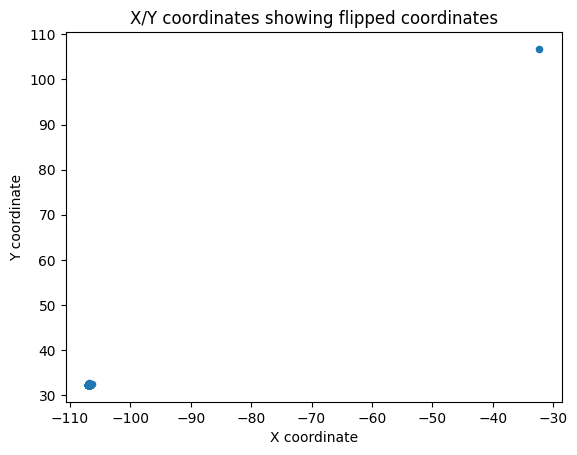

In [12]:
# Check coordinate issue
df.plot.scatter(x='X',y='Y')

plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('X/Y coordinates showing flipped coordinates')
plt.savefig(output_dir / "originalXY.jpg", dpi = 300, bbox_inches = "tight")
plt.show()

In [13]:
# Coordinates look to be switched on X/Y
# X should all start with -106
# Y should all start with 32
# -32, 106 is off the western coast of Australia
mask = (df['X'].astype(str).str.startswith('-32')) & (df['Y'].astype(str).str.startswith('106'))
df.loc[mask,['X','Y']] = df.loc[mask,['Y','X']].values
df.loc[mask, 'X'] = -abs(df.loc[mask, 'X'])  # ensure X is negative
df.loc[mask, 'Y'] = abs(df.loc[mask, 'Y'])   # ensure Y is positive
df[['X','Y']].describe()

,X,Y
count,66967.000000,66967.000000
mean,-106.755155,32.350141
std,0.027252,0.040081
min,-106.936823,32.255798
25%,-106.771419,32.317182
50%,-106.748858,32.353997
75%,-106.737228,32.389310
max,-106.366960,32.624210


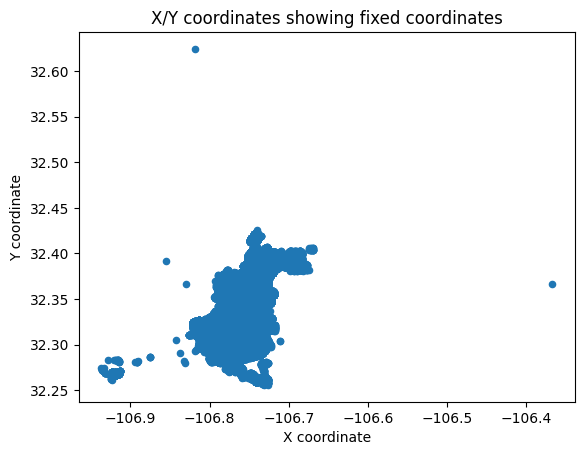

In [14]:
# Check coordinate issue to ensure the fix worked
df.plot.scatter(x='X',y='Y')

plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('X/Y coordinates showing fixed coordinates')
plt.savefig(output_dir / "flippedXY.jpg", dpi = 300, bbox_inches = "tight")
plt.show()

In [15]:
# List categorical attributes for review
print(df['Permit_Type'].value_counts(),'\n')
print(df['Project'].value_counts(),'\n')
print(df['RecTypeGrp'].value_counts())

Permit_Type
ELECTRICAL                 20810
PLUMBING                   18250
MECHANICAL                  9681
NEW                         6036
RE-ROOF                     5146
PERMIT                      1278
ALTERATION                  1172
PERMANENT                   1035
ADDITION                     761
ACCESSORY                    671
INSTALLATION                 432
POOL                         383
ZONING REVIEW                266
FIRE SPRINKLER               259
FIRE ALARM                   240
COMMUNICATION STRUCTURE      166
TEMPORARY                    135
SPECIAL SYSTEMS              107
FULL                          81
PARTIAL                       50
SERVICE LINE                   8
Name: count, dtype: int64 

Project
RESIDENTIAL         55061
COMMERCIAL           8629
FENCES AND WALLS     1278
SIGN                 1170
MOBILE HOME           432
WALL FENCE            266
DEMOLITION            131
Name: count, dtype: int64 

RecTypeGrp
OTHER          60049
RESIDENTIAL     5

In [16]:
# Remove additional attributes, keeping Issued_Date even with missing data for later seasonal investigation
# Remove RecTypeGrp since the majority is "other" and is of limited use, keep Project even though it is heavily weighted to Residential
df = df[['Permit_Type','Project','Project_Valuation','Issued_Date','Total_SQFT','PSFEE','PAFEE','UTFEE','CDFEE','TotalFeeInvoiced','X','Y']]
# Keep a working copy & a clean copy of df
df_model = df.copy()

In [17]:
# Output a copy of the cleaned & limited dataset
df_cleaned_small = df.copy()
outpath = data_dir / "building_permits_cleaned_small.csv"
df_cleaned_small.to_csv(outpath, index = False)

## Baseline Decision Tree
To test for feature importance, how to address fees, and to determine if coordinates and/or seasonality were factors for this classification, a baseline Decision Tree was created. The coordinates were tested in three ways (no transformations, trigonometric transformations, & clustering) and showed best performace with clustering, seasonality showed no impact. Some interactions were also tested to see if there were synergestic affects, though none showed a great impact.

- [x] Create a baseline Decision Tree classifier with selected attributes (excluding date and coordinates). Target initial accuracy >=75%.
    - [x] Use one-hot-encoding for 'Project'
    - [x] Save results (accuracy, weighted precision, weighted recall, weighted f1, feature importance) to list of dictionaries for later use
    - [x] Compare total vs. **individual** fee attributes.
       - Individual fees has a slight edge compared to the total fee. Kept CDFEE, PSFEE, and UTFEE for the model, but not PAFEE as it is not in the top 5 attributes, and accounts for less than 4.5% of the variance.
    - [x] Explore adding coordinates and check performance impact.
    - There are four options:
        - [x] Use direct coordinates with no processing
        - [x] Convert to spherical coordinates with trigonometric processing
        - [x] **Cluster** analysis
        - Distance based calculation to central feature. As the locations are dispersed and not centrally located around any feature, this will not be explored.
        - [x] Calculate number of clusters with elbow method & silhouette score
        - Six (6) clusters was chosen based on elbow & silhouette score results
    - [x] Group by cluster & compare mean values
    - [x] Plot Mean CDFEE / Mean project_valuation for each cluster and see if there are any interpretable results.
        - Cluster 1 has the highest valuation, but shows a lower ratio of valuation / fee - likely large, high-value commercial projects where the valuation overwhelms the fee.
        - Cluster 3 has the lowest mean value, but the highest ratrio of valuation / fee - likely smaller projects like home repairs/renovations, that, while lower in value, still have to pay the base fee which has an outsize affect on the ratio.
    - [x] Check for interactions for deeper relationships
        - CDFEE x Cluster adds slight amount of accuracy, combining more interactions just adds noise
    - [x] Explore seasonality for permit types
        - 2,964 records are missing dates and were not considered for seasonality
        - Any seasonal effect was very minor and could also just be noise. Seasonality will not be considered going forward.

In [18]:
def DecisionTreeModel(df, label):    
    # One hot encode categorical attributes Project
    df_encoded = pd.get_dummies(df,columns=['Project'])

    # Get X & y
    X = df_encoded.drop('Permit_Type', axis=1)
    y = df_encoded['Permit_Type']
    
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 72, stratify = y)
    
    # Set up classifier
    dt = DecisionTreeClassifier(random_state = 72)
    
    # Fit classifier
    dt.fit(X_train, y_train)
    
    # Predict test data
    y_pred = dt.predict(X_test)
    
    acc = round(accuracy_score(y_test, y_pred),3)
    
    return {
    "Label": label,
    "Accuracy": acc,
    "Report": classification_report(y_test, y_pred, zero_division=0, output_dict=True),
    "FeatureImportance":dict(zip(X_train.columns, dt.feature_importances_))
}

In [19]:
def extract_metrics(results):
    # Extract & print precision, recall, and f1 for each dataset
    for r in results:
        r['Precision'] = r['Report']['weighted avg']['precision']
        r['Recall'] = r['Report']['weighted avg']['recall']
        r['F1'] = r['Report']['weighted avg']['f1-score']

    results_df = pd.DataFrame(results)[['Label', 'Accuracy', 'Precision', 'Recall', 'F1']]
    return (results_df)

In [20]:
def top5features(results):
    # Extract & print the top 5 features for each dataset
    top_features = []
    for r in results:
        top_features.append({'Label': r['Label'],'Top5': sorted(
            r["FeatureImportance"].items(),
            key=lambda x: x[1],
            reverse=True
        )[:5]})

    return top_features

In [21]:
def print_results(results, top_features):
    # safety check
    if not results or not top_features:
        print("No results or feature data provided.")
        return

    # print metrics summary
    print("\n=== Model Performance Summary ===")
    results_df = pd.DataFrame(results)[['Label', 'Accuracy', 'Precision', 'Recall', 'F1']]
    print(results_df.to_string(index=False))

    # divider
    print("\n=== Top 5 Features per Model ===")
    for entry in top_features:
        print(f"\n{entry['Label']}:")
        for feature, importance in entry['Top5']:
            print(f"  {feature:<25} {importance:.3f}")


In [22]:
def build_viz_df(top_features):
    viz_data = []
    for entry in top_features:
        for feature, importance in entry['Top5']:
            viz_data.append({
                "Label": entry["Label"],
                "Feature": feature,
                "Importance": importance
            })
    viz_df = pd.DataFrame(viz_data)
    return viz_df

In [23]:
def plot_top_features(viz_df):
    labels = viz_df['Label'].unique()

    for label in labels:
        subset = viz_df[viz_df['Label'] == label][['Feature', 'Importance']]
        print(f"Preparing plot for {label}...")

        # create a new figure and axis for each plot
        fig, ax = plt.subplots(figsize=(8, 5))

        ax.barh(subset['Feature'], subset['Importance'], color='teal')
        ax.set_title(f"Top 5 Features – {label}")
        ax.set_xlabel("Importance")
        ax.invert_yaxis()
        fig.tight_layout()

        # save figure to the output folder
        fig.savefig(output_dir / f"{label}_top5.jpg", dpi=300, bbox_inches="tight")

        plt.show()


In [24]:
def plot_top_features(viz_df):
    labels = viz_df['Label'].unique()

    for label in labels:
        subset = viz_df[viz_df['Label'] == label][['Feature', 'Importance']]
        print(f"Preparing plot for {label}...")

        # create a new figure and axis for each plot
        fig, ax = plt.subplots(figsize=(8, 5))

        ax.barh(subset['Feature'], subset['Importance'], color='teal')
        ax.set_title(f"Top 5 Features – {label}")
        ax.set_xlabel("Importance")
        ax.invert_yaxis()
        fig.tight_layout()

        # save figure to the output folder
        fig.savefig(output_dir / f"{label}_top5.jpg", dpi=300, bbox_inches="tight")

        plt.show()


=== Model Performance Summary ===
   Label  Accuracy  Precision   Recall       F1
TotalFee     0.790   0.806665 0.790254 0.784007
  IndFee     0.798   0.814327 0.797720 0.792333

=== Top 5 Features per Model ===

TotalFee:
  TotalFeeInvoiced          0.565
  Project_Valuation         0.258
  Project_FENCES AND WALLS  0.042
  Project_SIGN              0.037
  Project_RESIDENTIAL       0.033

IndFee:
  CDFEE                     0.363
  Project_Valuation         0.250
  PSFEE                     0.115
  UTFEE                     0.102
  Project_RESIDENTIAL       0.045
Preparing plot for TotalFee...


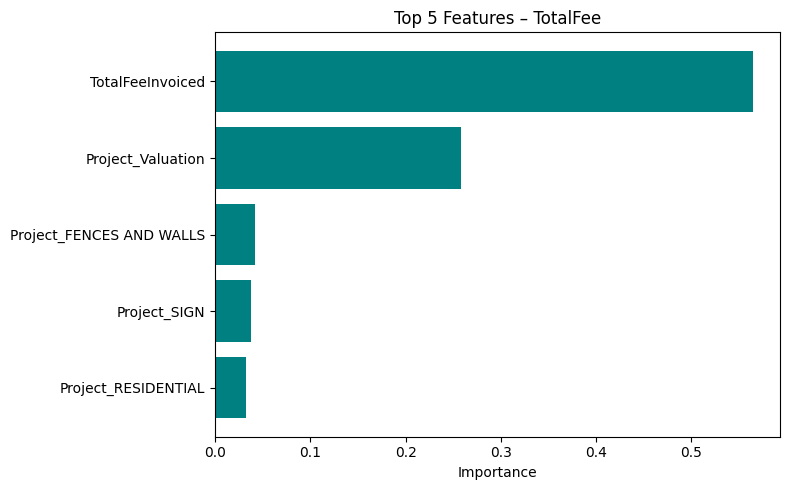

Preparing plot for IndFee...


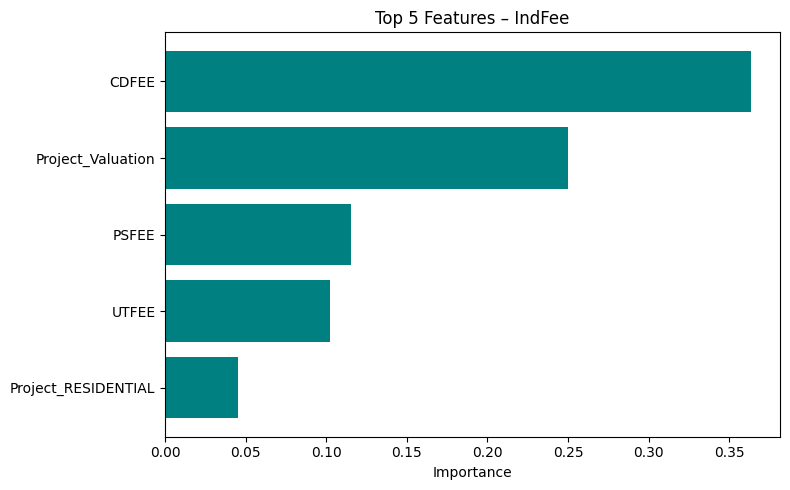

In [25]:
# Check to see if TotalFee or Individual fees give better results
# Using TotalFeeInvoiced
df_totalfee = df_model[['Permit_Type','Project','Project_Valuation','Total_SQFT','TotalFeeInvoiced']]

# Using PAFEE, PSFEE, CDFEE, UTFEE
df_indfee = df_model[['Permit_Type','Project','Project_Valuation','Total_SQFT','PSFEE','PAFEE','UTFEE','CDFEE']]

# Loop through dataframes and append to results list
dffee_list = [df_totalfee, df_indfee]
results = []
for label, df in [("TotalFee", df_totalfee), ("IndFee", df_indfee)]:
    results.append(DecisionTreeModel(df, label))

# Get metrics & top 5 features
results_df = extract_metrics(results)
top_features = top5features(results)

# Print results
print_results(results, top_features)
viz_df = build_viz_df(top_features)
plot_top_features(viz_df)

In [26]:
# Save new dataframe with selected attributes
df = df_cleaned_small[['Permit_Type','Project','Issued_Date','Project_Valuation','Total_SQFT','PSFEE','UTFEE','CDFEE','X','Y']].copy()
df_model = df_cleaned_small.copy()
df_model = df_model.drop('Issued_Date', axis=1)

### Spherical Coordinates

In [27]:
# Calculate the spherical coordinates using sin/cos trigonometric transformation
df_model['lat_sin'] = np.sin(np.deg2rad(df_model['Y']))
df_model['lat_cos'] = np.cos(np.deg2rad(df_model['Y']))
df_model['lon_sin'] = np.sin(np.deg2rad(df_model['X']))
df_model['lon_cos'] = np.cos(np.deg2rad(df_model['X']))

### Cluster Analysis

In [28]:
# Prior to cluster analysis, use elbow method to determine the best number of clusters
X = df_model[['X','Y']]
inertias = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters = k, random_state = 72)
    km.fit(X)
    inertias.append(km.inertia_)

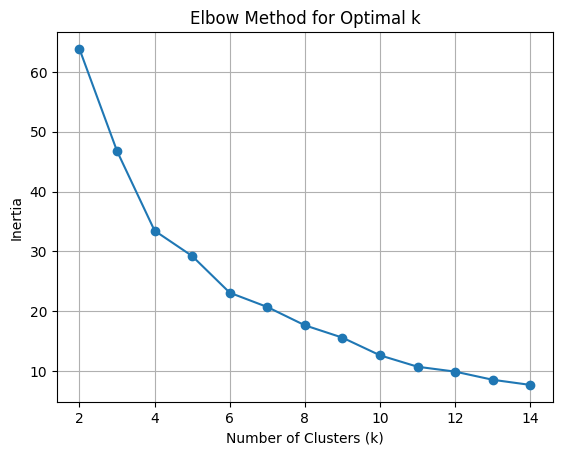

In [29]:
# Plot the elbow results
plt.plot(K, inertias, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.savefig(output_dir / "elbow.jpg", dpi = 300, bbox_inches = "tight")
plt.show()

The silhouette score calculations took 540.33 seconds


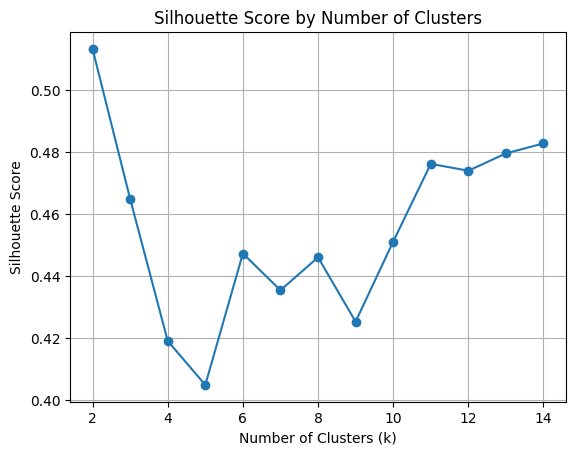

In [30]:
# Double check number of clusters with Silhouette score
silhouette_scores = []
K = range(2, 15)

# How long does the silhouette calculations take with 60k+ rows?
start_time = time.time()

for k in K:
    km = KMeans(n_clusters=k, random_state=72)
    labels = km.fit_predict(df_model[['X', 'Y']])
    score = silhouette_score(df_model[['X', 'Y']], labels)
    silhouette_scores.append(score)

end_time = time.time()

print(f'The silhouette score calculations took {end_time - start_time:.2f} seconds')

plt.plot(K, silhouette_scores, marker='o')
plt.title("Silhouette Score by Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.savefig(output_dir / "silhouette.jpg", dpi = 300, bbox_inches = "tight")
plt.show()

The silhouette score calculations took 15.91 seconds (on 10k sample)


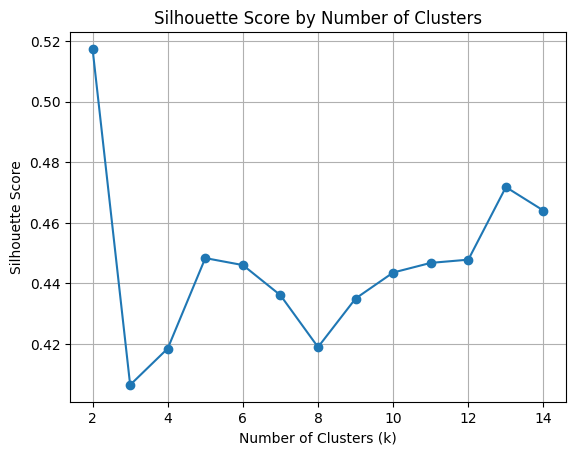

In [31]:
# Sampling option since the full silhouette score takes ~ 500 seconds
# Double check number of clusters with Silhouette score
silhouette_scores = []
K = range(2, 15)

# Sample a subset to speed up calculations
df_sample = df_model[['X', 'Y']].sample(10000, random_state=72)

start_time = time.time()

for k in K:
    km = KMeans(n_clusters=k, random_state=72)
    labels = km.fit_predict(df_sample)
    score = silhouette_score(df_sample, labels)
    silhouette_scores.append(score)

end_time = time.time()

print(f'The silhouette score calculations took {end_time - start_time:.2f} seconds (on 10k sample)')

plt.plot(K, silhouette_scores, marker='o')
plt.title("Silhouette Score by Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.savefig(output_dir / "silhouette_sampled.jpg", dpi=300, bbox_inches="tight")
plt.show()


In [32]:
# Using information from elbow/silhouette above, run clusters
X = df_model[['X','Y']]
kmeans = KMeans(n_clusters = 6, random_state = 72)
df_model['GeoCluster'] = kmeans.fit_predict(X)
df_model['GeoCluster'].value_counts().sort_index()

GeoCluster
0    10354
1    19994
2     3993
3    11622
4     9781
5    11223
Name: count, dtype: int64

In [33]:
# Calculate if any of the three location methods improve results
# Create the dataframes to test location methods
# Direct coordinates
df_direct = df_model.drop(['lat_sin','lat_cos','lon_sin','lon_cos','GeoCluster'],axis=1)

# Trigonometric processing
df_trig = df_model.drop(['X','Y','GeoCluster'],axis=1)

# Clusters
df_cluster = df_model.drop(['X', 'Y', 'lat_sin','lat_cos','lon_sin','lon_cos'], axis = 1)


=== Model Performance Summary ===
        Label  Accuracy  Precision   Recall       F1
     TotalFee     0.790   0.806665 0.790254 0.784007
       IndFee     0.798   0.814327 0.797720 0.792333
No Processing     0.771   0.771710 0.770644 0.770494
Trigonometric     0.798   0.814327 0.797720 0.792333
   Clustering     0.803   0.813522 0.803096 0.799033

=== Top 5 Features per Model ===

TotalFee:
  TotalFeeInvoiced          0.565
  Project_Valuation         0.258
  Project_FENCES AND WALLS  0.042
  Project_SIGN              0.037
  Project_RESIDENTIAL       0.033

IndFee:
  CDFEE                     0.363
  Project_Valuation         0.250
  PSFEE                     0.115
  UTFEE                     0.102
  Project_RESIDENTIAL       0.045

No Processing:
  TotalFeeInvoiced          0.214
  Project_Valuation         0.179
  Y                         0.122
  X                         0.113
  PSFEE                     0.090

Trigonometric:
  CDFEE                     0.363
  Project_Valuati

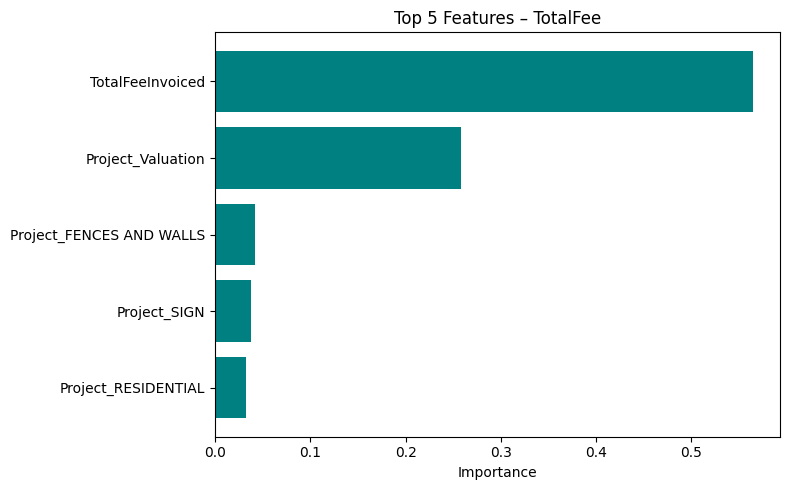

Preparing plot for IndFee...


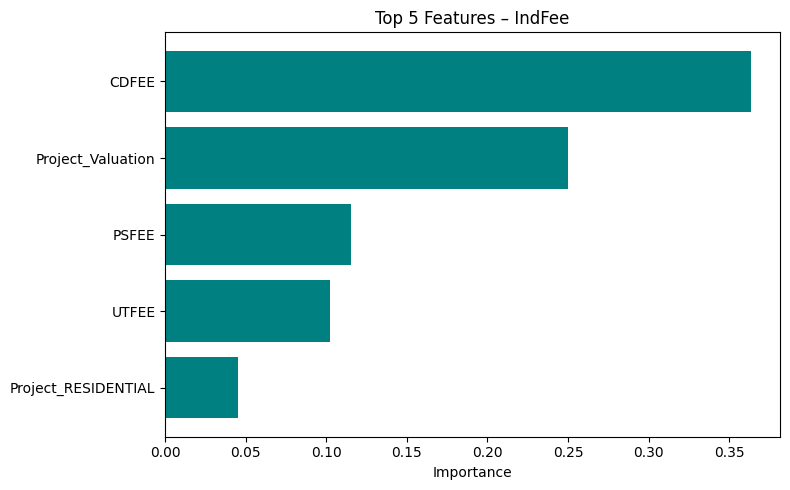

Preparing plot for No Processing...


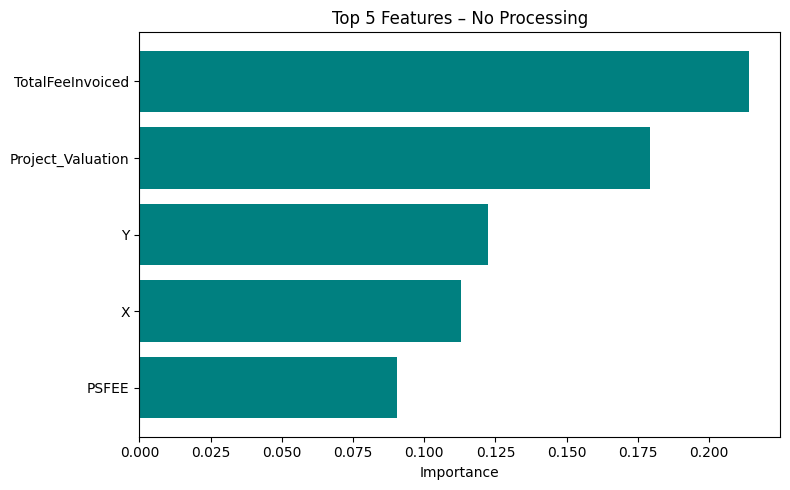

Preparing plot for Trigonometric...


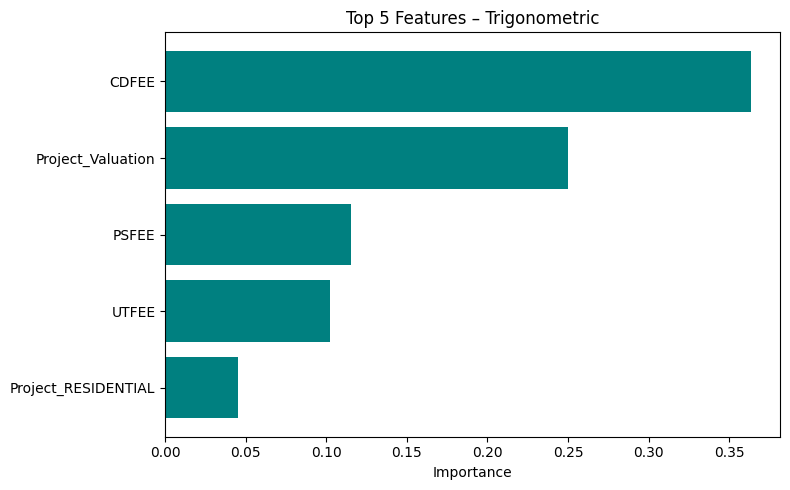

Preparing plot for Clustering...


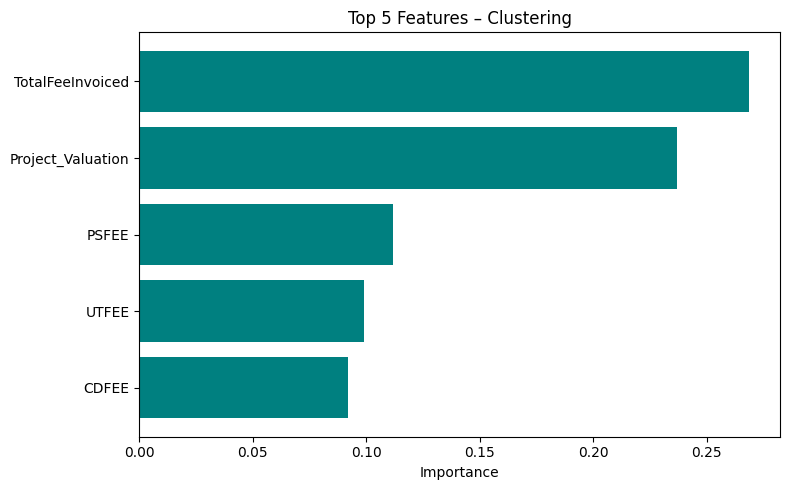

In [34]:
# Loop through location dataframes and append to results list that still contains the fee models
dffee_list = [df_direct, df_trig, df_cluster]
for label, df in [("No Processing", df_direct), ("Trigonometric", df_indfee), ("Clustering", df_cluster)]:
    results.append(DecisionTreeModel(df, label))
    
# Get metrics & top 5 features
results_df = extract_metrics(results)
top_features = top5features(results)

# Print results
print_results(results, top_features)
viz_df = build_viz_df(top_features)
plot_top_features(viz_df)

# Explore Interactions

In [35]:
# Possible Interactions
# Valuation x Cluster
df_valuation_cluster = df_cluster.copy()
df_valuation_cluster['ValuationxCluster'] = df_valuation_cluster['Project_Valuation'] * df_valuation_cluster['GeoCluster']

# SQFT x Cluster
df_SQFT_cluster = df_cluster.copy()
df_SQFT_cluster['SQFTxCluster'] = df_SQFT_cluster['Total_SQFT'] * df_SQFT_cluster['GeoCluster']

#CDFEE x Cluster
df_CDFEE_cluster = df_cluster.copy()
df_CDFEE_cluster['CDFEExCluster'] = df_CDFEE_cluster['CDFEE'] * df_CDFEE_cluster['GeoCluster']

# PSFEE x Cluster
df_PSFEE_cluster = df_cluster.copy()
df_PSFEE_cluster['PSFEExCluster'] = df_PSFEE_cluster['PSFEE'] * df_PSFEE_cluster['GeoCluster']

#UTFEE x Cluster
df_UTFEE_cluster = df_cluster.copy()
df_UTFEE_cluster['UTFEExCluster'] = df_UTFEE_cluster['UTFEE'] * df_UTFEE_cluster['GeoCluster']

# Using the two best interactions to see if results are better, worse, or similar
df_multi_interactions = df_cluster.copy()
df_multi_interactions['SQFTxCluster'] = df_multi_interactions['Total_SQFT'] * df_multi_interactions['GeoCluster']
df_multi_interactions['UTFEExCluster'] = df_multi_interactions['UTFEE'] * df_multi_interactions['GeoCluster']


=== Model Performance Summary ===
              Label  Accuracy  Precision   Recall       F1
           TotalFee     0.790   0.806665 0.790254 0.784007
             IndFee     0.798   0.814327 0.797720 0.792333
      No Processing     0.771   0.771710 0.770644 0.770494
      Trigonometric     0.798   0.814327 0.797720 0.792333
         Clustering     0.803   0.813522 0.803096 0.799033
Valuation x Cluster     0.802   0.812014 0.802100 0.797777
     SQFT x Cluster     0.803   0.813775 0.803345 0.799230
      CDFEExCluster     0.804   0.813817 0.803743 0.799300
      PSFEExCluster     0.803   0.812716 0.802648 0.798312
      UTFEExCluster     0.803   0.812949 0.802797 0.798610
 Multi_interactions     0.803   0.813096 0.802747 0.798520

=== Top 5 Features per Model ===

TotalFee:
  TotalFeeInvoiced          0.565
  Project_Valuation         0.258
  Project_FENCES AND WALLS  0.042
  Project_SIGN              0.037
  Project_RESIDENTIAL       0.033

IndFee:
  CDFEE                     0.363

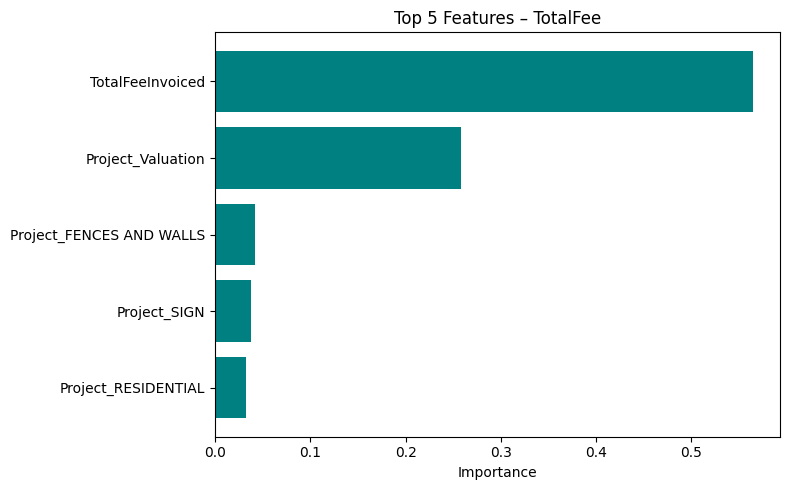

Preparing plot for IndFee...


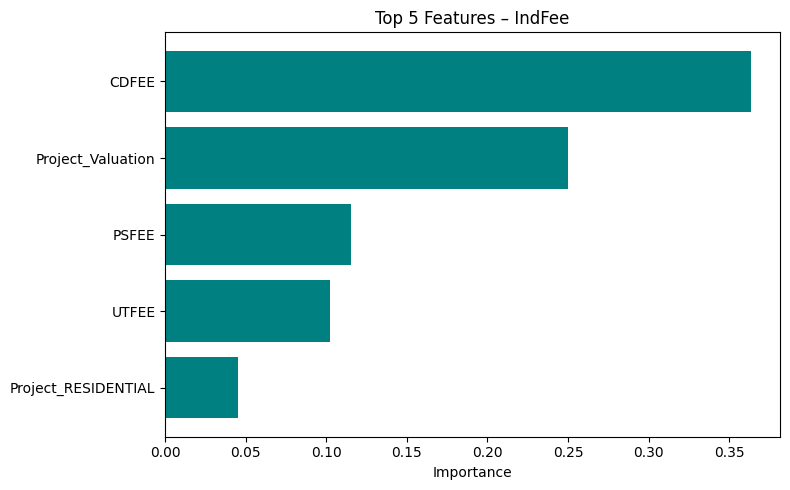

Preparing plot for No Processing...


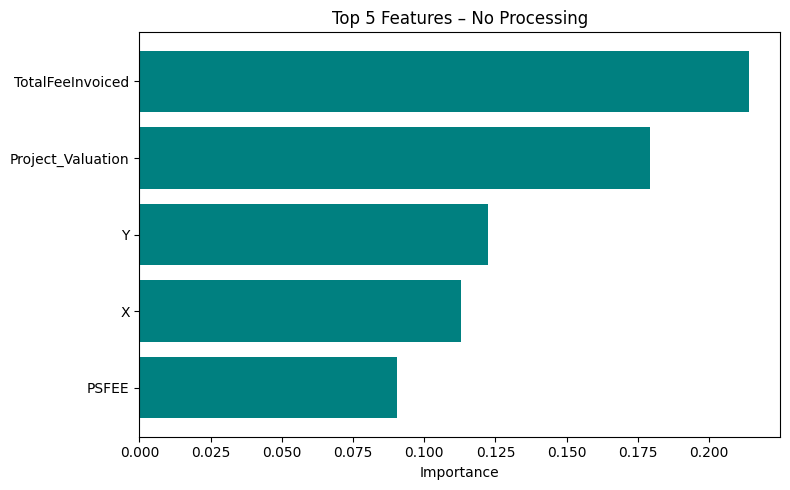

Preparing plot for Trigonometric...


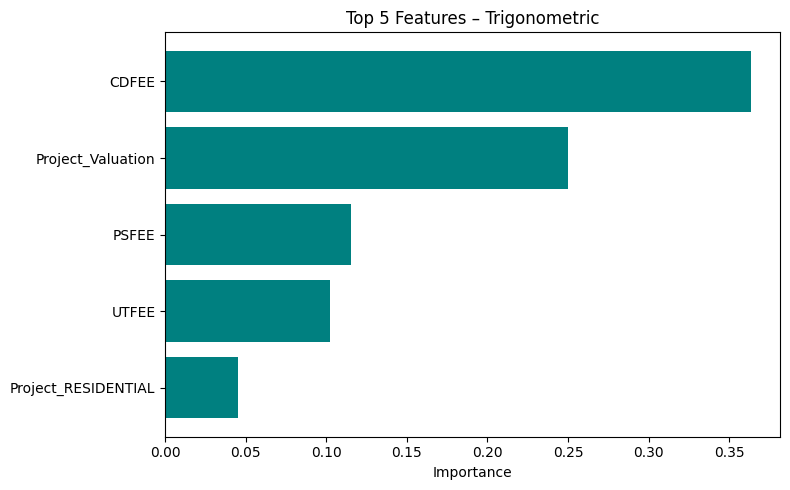

Preparing plot for Clustering...


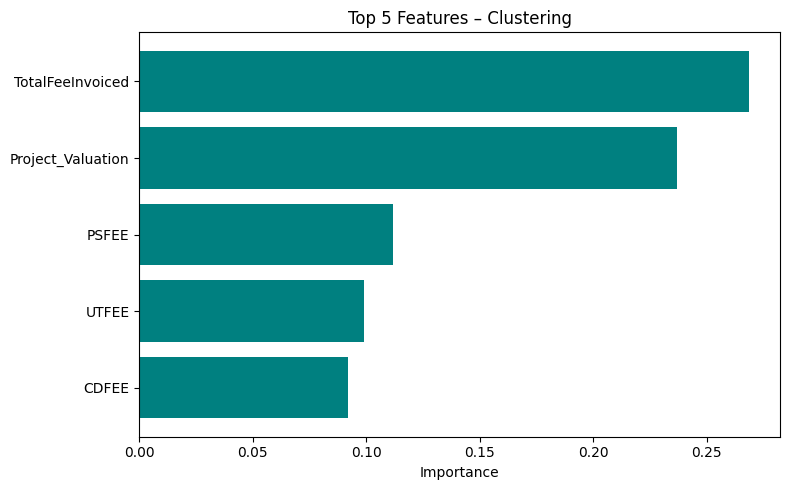

Preparing plot for Valuation x Cluster...


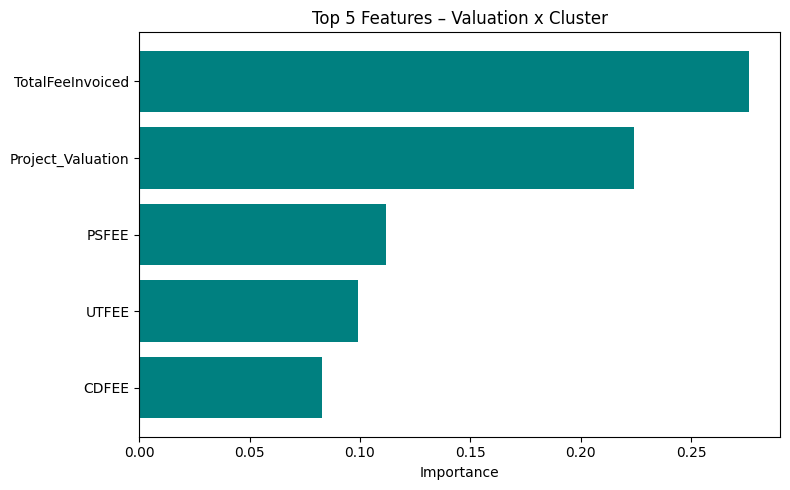

Preparing plot for SQFT x Cluster...


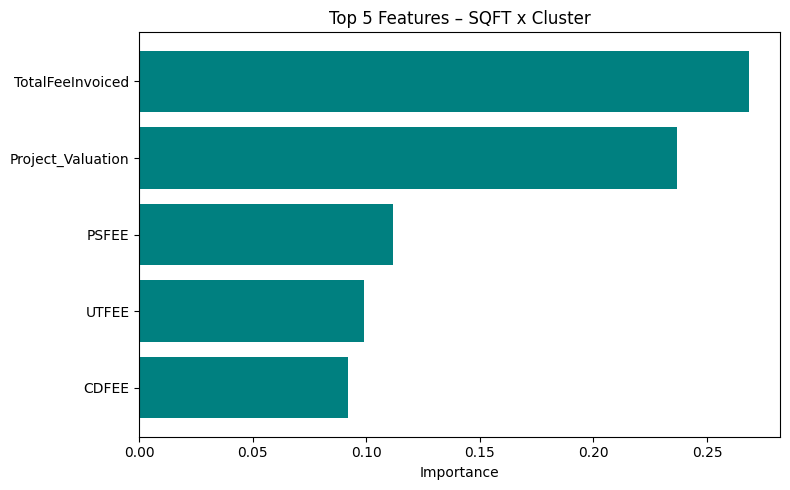

Preparing plot for CDFEExCluster...


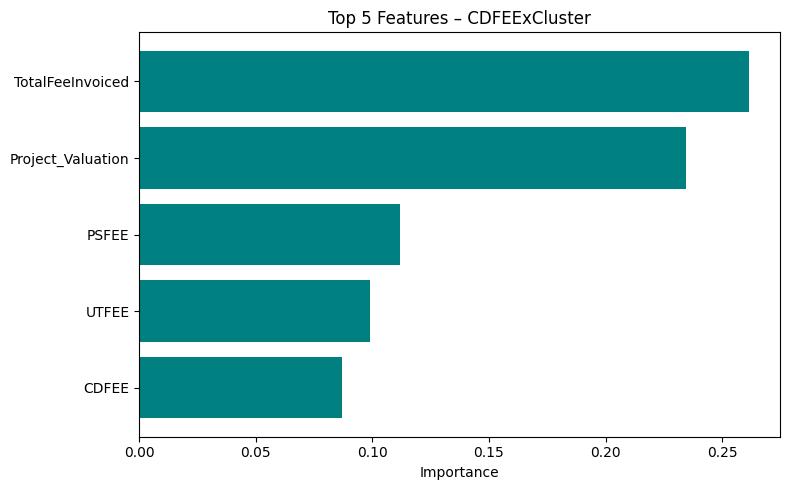

Preparing plot for PSFEExCluster...


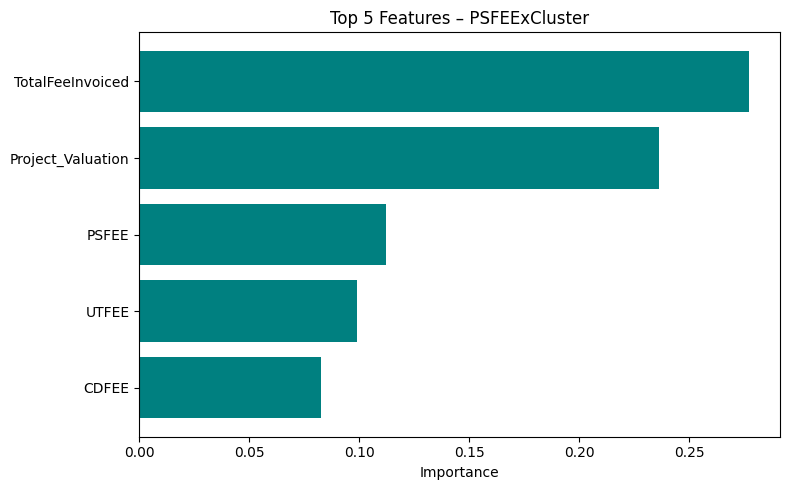

Preparing plot for UTFEExCluster...


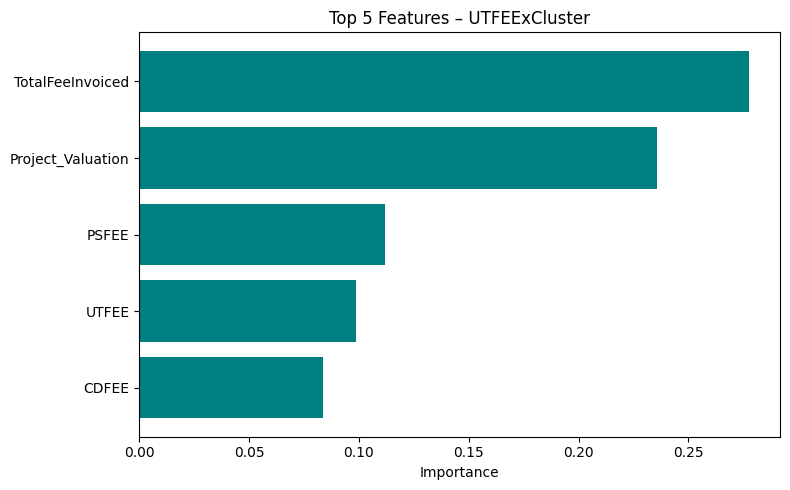

Preparing plot for Multi_interactions...


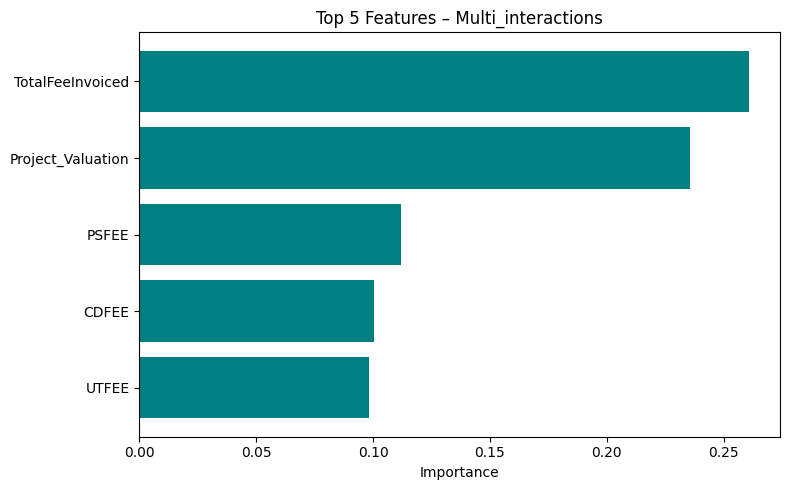

In [36]:
# Loop through dataframes and append to results list that still includes previous results
dffee_list = [df_valuation_cluster, df_SQFT_cluster, df_CDFEE_cluster, df_PSFEE_cluster, df_UTFEE_cluster, df_multi_interactions]
for label, df in [("Valuation x Cluster", df_valuation_cluster), ("SQFT x Cluster", df_SQFT_cluster),("CDFEExCluster",df_CDFEE_cluster),("PSFEExCluster",df_PSFEE_cluster),("UTFEExCluster",df_UTFEE_cluster),("Multi_interactions",df_multi_interactions)]:
    results.append(DecisionTreeModel(df, label))
    
# Get metrics & top 5 features
results_df = extract_metrics(results)
top_features = top5features(results)

# Print results
print_results(results, top_features)
viz_df = build_viz_df(top_features)
plot_top_features(viz_df)

### Group By Clusters

In [37]:
# Group By to understand clusters
grouped_values = df_cluster.groupby("GeoCluster").agg(
    mean_val=("Project_Valuation", "mean"),
    mean_sqft=("Total_SQFT", "mean"),
    mean_CDFEE=("CDFEE", "mean"),
    mean_UTFEE=("UTFEE", "mean"),
    top_permit=("Permit_Type", lambda x: x.value_counts().idxmax())
)
# Add ratio of fee to value
grouped_values['ratio'] = grouped_values['mean_CDFEE'] / grouped_values['mean_val']
cluster_counts = df_cluster['GeoCluster'].value_counts()
grouped_values['ClusterCount'] = grouped_values.index.map(cluster_counts)
grouped_values.sort_values("ratio", ascending=False)

,mean_val,mean_sqft,mean_CDFEE,mean_UTFEE,top_permit,ratio,ClusterCount
GeoCluster,,,,,,,
3,21684.520392,64.188264,176.378634,113.525310,ELECTRICAL,0.008134,11622
4,27012.699315,80.782844,203.134771,119.188754,ELECTRICAL,0.007520,9781
5,44105.378687,280.635035,241.349482,399.918944,ELECTRICAL,0.005472,11223
0,34508.724937,250.594746,187.203762,256.633078,ELECTRICAL,0.005425,10354
2,39907.460556,205.022039,206.951625,196.578387,ELECTRICAL,0.005186,3993
1,48991.986296,340.242623,179.049966,239.685136,ELECTRICAL,0.003655,19994


In [38]:
# Check means & ratio - ensure no divide by zero issue
grouped_values[['mean_val','mean_CDFEE','ratio']].sort_values("ratio", ascending=False)

,mean_val,mean_CDFEE,ratio
GeoCluster,,,
3,21684.520392,176.378634,0.008134
4,27012.699315,203.134771,0.007520
5,44105.378687,241.349482,0.005472
0,34508.724937,187.203762,0.005425
2,39907.460556,206.951625,0.005186
1,48991.986296,179.049966,0.003655


### Plot fee efficiency

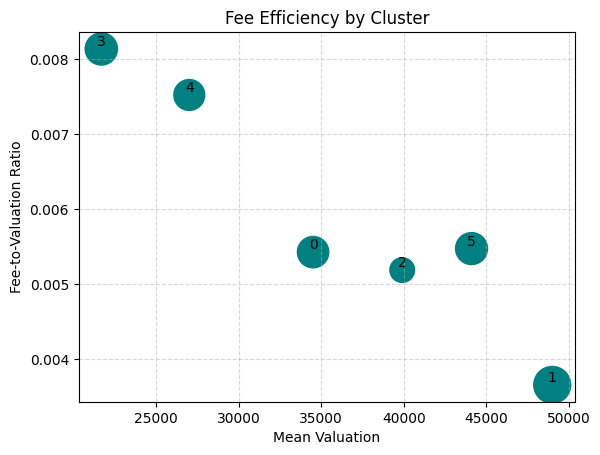

In [39]:
# Plot fee efficiency (CDFEE / Valuation) clusters with dot size determined by count of values in the cluster. CDFEE & Valuation are consistently the top two features in the model.
plt.scatter(
    grouped_values['mean_val'],
    grouped_values['ratio'],
    s=np.sqrt(grouped_values['ClusterCount']) * 5,
    color='teal'
)
for i, row in grouped_values.iterrows():
    plt.text(row["mean_val"], row["ratio"], str(i), va="bottom", ha="center")
plt.xlabel("Mean Valuation")
plt.ylabel("Fee-to-Valuation Ratio")
plt.title("Fee Efficiency by Cluster")
plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig(output_dir / "fee_efficiency.jpg", dpi=300, bbox_inches="tight")
plt.show()

## Cluster interpretation
Cluster 1 has the highest valuation, but shows a lower ratio of valuation / fee. Cluster 3 has the lowest mean value, but the highest ratrio of valuation / fee. It seems reasonable that cluster 1 includes large, high-value commercial projects that either were granted some form of fee exemption, or the higher valuation overwhelms the base fee. Cluster 3 is likely smaller projects like home repairs/renovations, that, while lower in value, still have to pay the base fee which has an outsize affect on the ratio.

# Does seasonality matter?

<Axes: xlabel='Month'>

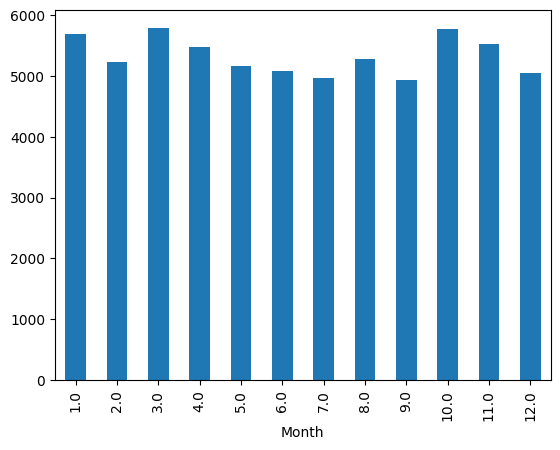

In [40]:
df = df_cleaned_small[['Permit_Type','Project','Issued_Date','Project_Valuation','Total_SQFT','PSFEE','UTFEE','CDFEE','X','Y']].copy()
df.loc[:, 'Month'] = pd.to_datetime(df['Issued_Date']).dt.month
df.groupby('Month')['Permit_Type'].count().plot(kind='bar')


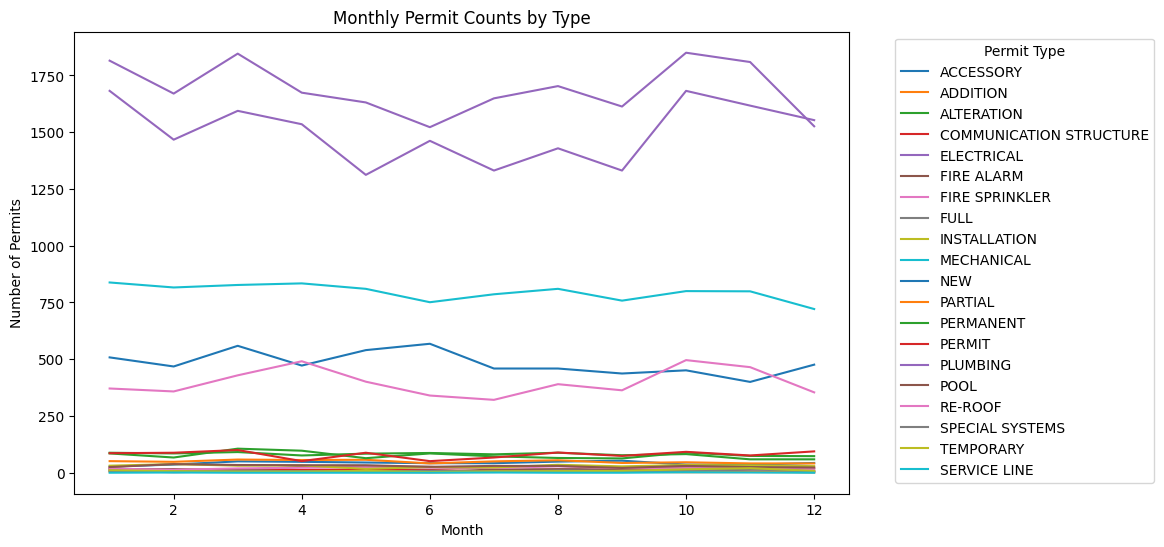

In [41]:
# Extract month
df.loc[:, 'Month'] = pd.to_datetime(df['Issued_Date']).dt.month

# Group by month and permit type, count rows
monthly_counts = df.groupby(['Month', 'Permit_Type']).size().unstack(fill_value=0)

# Plot each type as a small multiple
monthly_counts.plot(kind='line', figsize=(10,6))
plt.title("Monthly Permit Counts by Type")
plt.ylabel("Number of Permits")
plt.xlabel("Month")
plt.legend(title="Permit Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(output_dir / "permit_seasonality.jpg", dpi=300, bbox_inches="tight")
plt.show()

In [42]:
# Save final dataset for next step
df_final = df_cluster.copy()
outpath = data_dir / "building_permits_final.csv"
df_final.to_csv(outpath, index = False)

In [43]:
# Check for missing data before running the pipeline, just in case
df_final.isna().sum()

Permit_Type          0
Project              0
Project_Valuation    0
Total_SQFT           0
PSFEE                0
PAFEE                0
UTFEE                0
CDFEE                0
TotalFeeInvoiced     0
GeoCluster           0
dtype: int64

## Test Additional Models
To better understand different approaches, I tested several models against the selected dataset, knowing each perform better under specific conditions. This dataset is a mix of numerical and categorical variables, is multi-class, and heavily right-skewed. Some models were included even when low performance was expected, to observe how each technique handled the data.

- [x] **Decision Tree** - A single tree that can model complex patterns but can be sensitive to small data changes. Serves as a baseline for comparison, especially with ensemble methods.
    - _**Result**: Performed well, with accuracy slightly below ensemble models and well above other models._
- [x] **Random Forest** - An ensemble of Decision Trees that generally improves performance.
    - _**Result**: Performed slightly better than the single Decision Tree._
- [x] **Logistic Regression** - Best suited for binary, evenly distributed data. Unlikely to perform well on this dataset.
    - _**Result**: Accuracy was poor with a multi-class, uneven dataset._
- [x] **Naive Bayes** - Assumes all features are independent, which is not true for this dataset.
    - _**Result**: Accuracy was poor confirming the assumption of independence doesn't fit this dataset._
- [x] **K Nearest Neighbors (KNN)** - Works best when nearby data points share similar labels; can be sensitive to scaling & noise. This model is expected to perform at mid-level at best.
    - _**Result**: moderate performance given the dataset features._
- [x] **Support Vector Machine (SVM)** - Performs best with smaller datasets with clear class boundaries.
    - _**Result**: Lower performance as expected on a complex, mixed-type dataset._
- [x] **XGBoost** - An ensemble model like Random Forest, but instead of parallel development, a sequential format where each tree informs the next. This is likely to increase performance over both Decision Tree and Random Forest.
     - _**Result**: Best overall performance, validating expectations for boosted models._
 
This model comparison hightlights how different approaches handle complex, real-world data. In this case, tree-based (Decision Tree) and ensemble models (Random Forest, XGBoost) performed best as they are able to handle nonlinear relationships and complex datasets. Simpler models such as Logistic Regression, SVM, & Naive Bayes struggled with this dataset due to size, complexity, the uneven multi-class distribution, and independence assumption. KNN showed moderate results, but did not exceed the baseline Decision Tree.

In [44]:
start_time = time.time()

results = []

# Create dictionary of models for testing, include decision tree to ensure all models are processed identically
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=72),
    'Random Forest':RandomForestClassifier(random_state=72),
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'Naive Bayes': GaussianNB(),
    'KNN':KNeighborsClassifier(),
    'SVM':SVC(),
    'XGBoost': XGBClassifier(eval_metric='mlogloss',random_state=72),
    }

# Define X, y from final dataset above
X = df_final.drop('Permit_Type', axis = 1)
y = df_final['Permit_Type']

# Encode the target for models that require it
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Identify categorical columns & encode
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(exclude=['object']).columns

# Transformer to handle categorical and numeric differently
# Some models don't need scaling (Random Forest, XGBoost)
# ColumnTransformer ensures consistent processing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Stratify folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=72)

# Run models through pipeline & score
for name, model in models.items():
    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])

    scores = cross_val_score(pipe, X, y_encoded, cv=cv, scoring='accuracy')
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    results.append({'Model': name, 'Mean': mean_score, 'Std': std_score})

# Turn results into a DataFrame for easy viewing
results_df = pd.DataFrame(results).sort_values(by='Mean', ascending=False)

# Find the top model name
best_model_name = results_df.iloc[0]['Model']
print(f"\nBest model: {best_model_name}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Model search with cross validation completed in {elapsed_time/60:.2f} minutes")
print(results_df)


Best model: XGBoost
Model search with cross validation completed in 16.98 minutes
                 Model      Mean       Std
6              XGBoost  0.814834  0.000947
1        Random Forest  0.808383  0.002097
0        Decision Tree  0.805128  0.001425
4                  KNN  0.748533  0.003287
2  Logistic Regression  0.549599  0.008911
5                  SVM  0.479535  0.004046
3          Naive Bayes  0.235489  0.003171


## Next Steps
This is a work in progress and will evolve over time. Planned next steps include:
- [ ] Tune XGBoost model hyperparameters to improve performance
- [ ] Validate model stability by testing across data subsets and random seeds
- [ ] Analyze feature influence to undertand key drivers behind predictions
- [ ] Finalize and expport model
- [ ] Finalize documentation of process